In [4]:
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Ver Código"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

# Proyecto final métodos computacionales

La propuesta realizada para la realización de este trabajo se centra en realizar el cálculo mediante métodos númericos de cómo debe ser (idealmente) la curva generada por una cuerda sin rigidez flexional, suspendida de sus dos extremos a la misma altura y sometida a un campo gravitatorio uniforme; comparando el resultado obtenido con el resultante de análisis variacional.

Con el fin de realizar esto se parte de la minimización de la energía potencial de la cuerda mientras se mantiene una longitud constante, esta energía potencial está modelada por la integral

$$
E_p = - \rho g \int_{-a}^a y (1 + (y')^2)^{1/2} dx
$$

de donde se tiene que las varibles son iguales a 

- $\rho:$ Densidad lineal de la cuerda.
- $g:$ Aceleración gravitacional del planeta.
- $a:$ Distancia horizontal desde el centro de la cuerda hasta uno de sus extremos.
- $y:$ Función que modela la forma de la cuerda.

Al realizar operaciones de cálculo de variaciones con el fin de minimizar esta integral se obtiene la ecuación diferencial

$$
\left(\frac{dy}{dx} \right)^2 = \left(\frac{\rho g y + \lambda}{k}\right)^2 - 1
$$

y dado que el resultado es una forma real, se toma la raiz haciendo uso del valor absoluto, obteniendo la ecuación a resolver

$$
\frac{dy}{dx} = \sqrt{\left(\frac{\rho g y + \lambda}{k}\right)^2 - 1}
$$

de donde, $k$ es una constante de integración, la cual es igual a 

$$
k = \frac{\rho g a}{\sinh^{-1}\left(\frac{L \rho g}{k} \right)}
$$

en donde $L$ es igual a la longitud de la cuerda partida a la mitad; además de esto se tiene a $\lambda$, la cual es consecuencia del uso de multiplicadores de Lagrange, y, si se tiene en cuenta como condición inicial que $y(\pm a) = 0$ es igual a

$$
\lambda = k \cosh\left(\frac{\rho g a}{k} \right)
$$

En este código se utilizan diversos métodos númericos para obtener una gráfica para $y(x)$ y se compara con el resultado análitico, siendo este

$$
y(x) = \frac{1}{\rho g} \left[k \cosh\left(\frac{\rho g x}{k} \right) - \lambda \right]
$$

In [1]:
#Lo primero que se hace es importar las librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from matplotlib import animation
from IPython.display import HTML

A continuación se definen las variables a utilizar, pudiendo ser cambiadas en cualquier momento, pero serán estas con las que se probará el código

In [2]:
L = 10
rho = 0.98
g = 9.8
a = 4

En el siguiente bloque se encuentra un código oculto, en el cual se encuentran todas las rutinas importadas de clase que serán necesarias para la realización del código, entre estas están:

- Método de Steffensen para hallar raices.
- Método de integración de Simpson.
- Método de integración Gaussiana.

El bloque debe ser desvelado y corrido (no sin antes tambien correr el que está antes del título del notebook)

In [5]:
def Steffensen2(g,p0):
    i=1
    eps=1e-9
    while True:
        p1 = g(p0)
        p2 = g(p1)
        
        p = p0 - ((p1 - p0)**2)/(p2 - 2*p1 + p0)
        
        if(np.abs(p-p0)>=eps):
            i+=1
            p0=p
        else:
            return p
            break

def Simpson2(x,y):
    n = len(x) - 1
    hn = x[n] - x[n-1]
    h0 = x[1] - x[0]
    S0 = y[0]*h0 + y[n]*hn # inicialice
    S1 = 0
    S2 = 0
    for i in range(1,n):   # suma en 1, ..., n-1
        hi = x[i+1] - x[i]
        if (i%2==0):         
            S2 += y[i]*hi     # suma de f(2xi) si i es par
        else:
            S1 += y[i]*hi     # suma de f(2x[i-1]) si i es impar
    return (S0 + 2*S2 + 4*S1)/3 

def gauss(n,job, a,b,x,w, eps = 3.E-15 ):
    """
    -------------------------------------------------------------------------
    # Metodo de Cuadratura Gaussiana (Gauss–Legendre quadratura) usando n   #
    # puntos en el intervalo [a,b], x y w arreglos con los puntos xi (ceros #
    # del polinomio de Legendre P_n(x)) y pesos wi, eps es el error deseado,# 
    # job es:                                                               #
    #        0 para integración en [a, b]                                   #
    #        1 para integración en [0, b]                                   #
    #        2 para integración en [a, inf]                                 #
    -------------------------------------------------------------------------
    """    
    m = (n + 1)//2 # Por simetria, solo se calcula la mitad de las raíces.
    for i in range(1, m + 1): # Bucle para encontrar las raíces y los pesos.
        t = np.cos(np.pi*(i - 0.25)/(n + 0.5) ) # Suposición inicial de la 
        t1 = 1                                  # i-esima raiz de orden n.
        while( (np.abs(t - t1) ) >= eps):       # Newton iteration para
            p1 = 1. ; p2 = 0.                   # encontrar la raíz i-esima.
            for j in range(1, n + 1):
                p3 = p2                         # Relación de recurrencia de 
                p2 = p1                         # P_n(x).
                p1 = ( (2.*j - 1)*t*p2 - (j - 1.)*p3)/j
                                                # Relación de recurrencia de 
            pp = n*(t*p1 - p2)/(t*t - 1.)       # P'_n(x): Derivada de P_n(x).
            t1 = t
            t  = t1 - p1/pp                     # xi = x - P_n(x)/P'_n(x).

        x[i - 1] = - t      # Guardar la raiz encontrada y
        x[n - i] = t        # por simetria esta es la otra raiz no calculada.
        w[i - 1] = 2./( (1. - t*t)*pp*pp)       # Guardar peso.
        w[n - i] = w[i - 1]                     # Guardar, usando simetria.
        # print(" x[i - 1]", x[i - 1] , " w " , w[n - i])
    if (job == 0):
        for i in range(0, n):
            x[i] = x[i]*(b - a)/2. + (b + a)/2. # Transformación de [-1,1] al
            w[i] = w[i]*(b - a)/2.              # intervalo [a, b].
            
    if (job == 1):
        for i in range(0, n):
            xi = x[i]
            x[i] = a*b*(1. + xi)/(b + a - (b - a)*xi)
            w[i] = w[i]*2.*a*b*b/( (b + a - (b - a)*xi)**2. )
            
    if (job == 2):
        for i in range(0, n): #4
            xi = x[i]
            x[i] = (b*xi + b + a + a)/(1. - xi)
            w[i] = w[i]*2.*(a + b)/( (1. - xi)**2. )  
            
def Integral_Gauss(f, a, b, n):
    """
       Integral de f(x) en [a,b] usando el metodo de Gauss con n puntos. 
    """
    w = np.zeros(n)           # contendrá los ceros de los pols. de Legendre
    x = np.zeros(n)           # contendrá los pesos w para la integración

    gauss(n, 0, a, b, x, w)   # Retorna puntos xi y wi

    return sum(f(x)*w)        # Calcule integral    

display(HTML(toggle_code_prepare_str + toggle_code_str))

Ahora bien, se quiere hallar el valor de $k$ utilizando la ecuación mostrada arriba, para esta las posibilidades más claras son, el uso de punto fijo o el método de Steffensen (el cual será el utilizado).

En primer lugar se realizará una gráfica de observación para tener una buena certeza de en que valor inicializar Steffensen

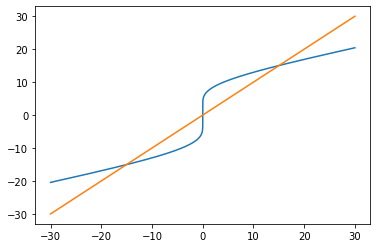

In [6]:
#Función a la que es igual k
f = lambda k: (a*rho*g)/(np.arcsinh((rho*g*L)/(k))) 

x = np.arange(-30,30,0.001)

plt.plot(x,f(x))
plt.plot(x,x)
plt.show()

Sabiendo esto se utiliza el método para calcular el valor de $k$, y con este obtener el valor de $\lambda$

In [7]:
#Implementación del método de Steffensen
k = Steffensen2(f, -10)

lam = k * np.cosh((rho*g*a)/(k))
print(f'valor de k obtenido {np.round(k,3)} y valor de lambda calculado {np.round(lam,3)}')

valor de k obtenido -15.049 y valor de lambda calculado -97.212


Ahora se procede a realizar el calculo de la solución a la ecuación diferencial, cabe resaltar que antes de este notebook el cálculo ya fue realizado para los métodos de Euler, RungeKutta2 y RungeKutta4, pero, como se obtuvo el mismo resultado para los tres métodos se decidió presentar en este la solución solo para euler

para esto se tiene en cuenta la ecuación diferencial enunciada arriba y se define la función

$$
\frac{y_{i+1} - y_i}{\Delta x} = g(y_i,x_i) = \sqrt{\left|\left(\frac{\rho g y_i + \lambda}{k}\right)^2 - 1\right|}
$$

De lo cual, despejando las posiciónes futuras se obtiene que

$$
y_{i+1} = g(y_i,x_i)\Delta x + y_{i}
$$

Ecuación que se utiliza para calcular los valores de la función catenaria (nombre de la forma) mediante iteraciones.

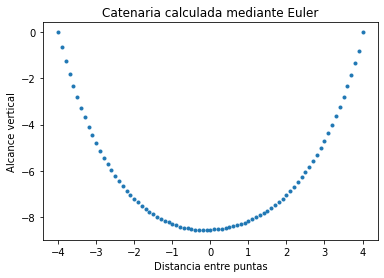

In [27]:
#Definición de la función g
def g0(y,k,lam,rho,g,x):
    return np.sqrt(abs(((lam + rho*g*y) / (k))**2 - 1))

#Determinación de un dx optimo y los puntos inial y final
dx = 0.1
x0 = -a
xf = a

#Arreglo de posiciónes
x = np.arange(x0,xf+dx,dx)

#Inicialización de la función
y = np.zeros(len(x))

#Condicion inicial
y[0] =  0

#Cambio de concavidad
x_ = np.arange(-a,-0.2+dx,dx)

#Iteraciones para el cálculo de la forma
for i in range(0,len(x_)-1):
    y[i+1]=g0(y[i],k,lam,rho,g,x[i])*dx + y[i]
    
for i in range(len(x_)-1,len(x)-1):
    y[i+1]=-g0(y[i],k,lam,rho,g,x[i])*dx + y[i]

#Condicion inicial
y[-1] = 0

plt.plot(x,-y,'.')
plt.title('Catenaria calculada mediante Euler')
plt.xlabel('Distancia entre puntas')
plt.ylabel('Alcance vertical');

Ahora, con el finde de obtener una función suave que se ajuste a estos puntos se utiliza la función CubicSpline de Scipy para realizar interpolación por splines cubicos.

Se utilzia la condición de frontera periodica, pues es lo que se cumple $S(x_0) = S(x_f) = 0$

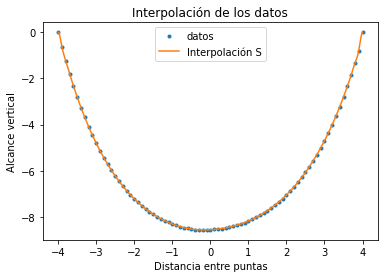

In [28]:
Sj = CubicSpline(x, y, bc_type='periodic')
x__ = np.arange(x0,xf+0.01,0.01)

plt.plot(x, -y,".",label="datos")   # datos para hacer los splines
plt.plot(x__, -Sj(x__),label="Interpolación S")# datos interpolados
plt.title('Interpolación de los datos')
plt.xlabel('Distancia entre puntas')
plt.legend()
plt.ylabel('Alcance vertical');

Con esto se obtiene una forma que, a primera vista, se observa muy similar a lo conocido como catenaria, pero para confirmar, se compara con la función análitica.

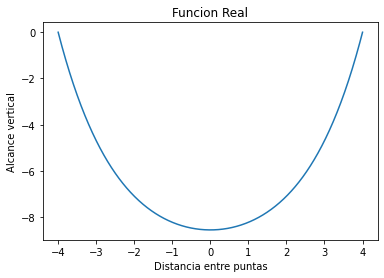

In [29]:
y = lambda x: 1/(rho*g) * (-lam + k* np.cosh((rho*g*x)/(k)))
    
x = np.arange(-a,a+0.01,0.01)

plt.plot(x,-y(x))
plt.title('Funcion Real')
plt.xlabel('Distancia entre puntas')
plt.ylabel('Alcance vertical');

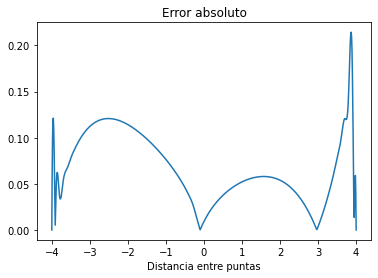

In [30]:
#Observación rápida del error absoluto al comparar lo obtenido mediante el método de Euler y la función real
plt.plot(x__, abs(Sj(x__)-y(x)))
plt.title('Error absoluto')
plt.xlabel('Distancia entre puntas');

Finalmente, aprovechando que le método de Splines cúbicos tambien otorga valores para la derivada se comparan los resultados obtenidos mediante distintos métodos de integración, simpson para el método númerico y gauss para la función real

In [33]:
xi = np.linspace(-a, a, 1001)
yi = Sj(xi)*(1 + (Sj(xi, 1))**2)**0.5

Simp = -1*rho*g*Simpson2(xi,yi)
Gau = Integral_Gauss(lambda x: -1*(-lam + k* np.cosh((rho*g*x)/(k))) * (1 + (-np.sinh((rho*g*x)/(k)))**2)**0.5 , -a, a, 10)

print(f'Valor de la energía potencial cálculada es {np.round(Simp,3)} J, y el real es {np.round(Gau,3)} J')

Valor de la energía potencial cálculada es -914.935 J, y el real es -911.922 J


Ahora bien, esto es realizable para distintos valores de $a$, para lo cual se pueden obtener resultados mejores o peores, lo que se realiza a continuación es que mediante seguidas iteraciones se realiza el procedimiento para distintos valroes de $a$ y se imprime un gif con todos los resultados obtenidos hasta el momento, esto se realiza con Euler, y tambien con RK4, esto con el fin de demostrar lo ídenticas que son los resultados.

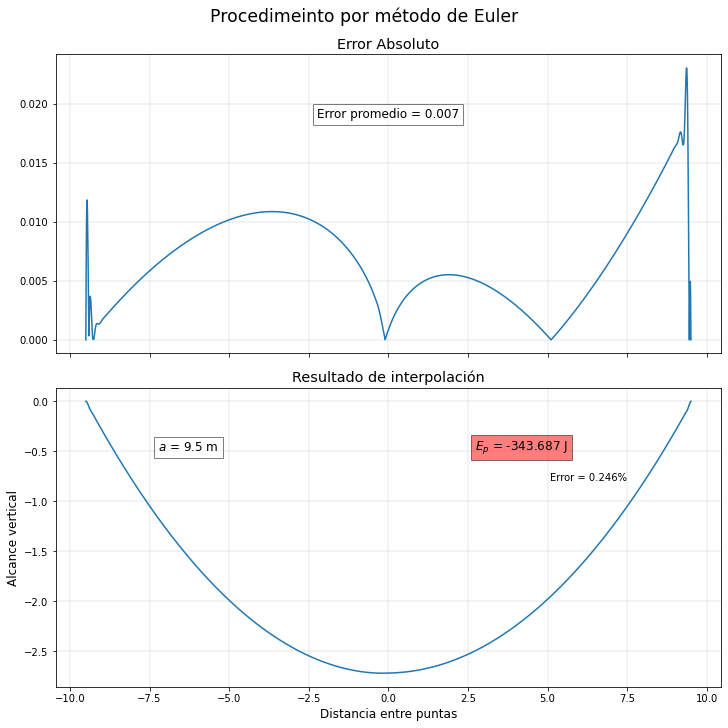

In [35]:
#incialización de las gráficas
fig, ax = plt.subplots(2,1, constrained_layout=True, figsize=(10,10),sharex=True)
line, = ax[0].plot([],[])
line2, = ax[1].plot([],[])

#Valores iniciales para los textos que se montan en las gráficas
ep = 0
er = 0
ap = 0
en = ax[1].text(0.7,0.8,f'$E_p$ = {ep} J',horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes,
                bbox=dict(facecolor='red', alpha=0.5), fontsize ='large')

enr =ax[1].text(0.8,0.7,f'Error = {er}%',horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes, 
                 fontsize ='medium')

an = ax[1].text(0.2,0.8,f'$a$ = {ap} m',horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes,
                bbox=dict(facecolor='white', alpha=0.5), fontsize ='large')

errprom = ax[0].text(0.5,0.8,f'Error promedio = {ap}',horizontalalignment='center',verticalalignment='center',transform=ax[0].transAxes,
                bbox=dict(facecolor='white', alpha=0.5), fontsize ='large')

#Titulo general y para los ejes coordenados
fig.suptitle('Procedimeinto por método de Euler',fontsize='xx-large')

ax[0].set_title('Error Absoluto',fontsize='x-large')
ax[1].set_title('Resultado de interpolación',fontsize='x-large')

ax[1].set_xlabel('Distancia entre puntas',fontsize='large')
ax[1].set_ylabel('Alcance vertical',fontsize='large')


ax[0].grid(True,linewidth=0.3)
ax[1].grid(True,linewidth=0.3)

#Arreglo con los valores en los que irá a
func_args = np.linspace(0.5,10-0.5,30)

#Acomodación de los valores del arreglo con el fin de que el método de Steffensen no presente problemas.
func_args[0] = 0.75
func_args[8] = 3
func_args[18] = 6
func_args[-3] = 8.8
func_args[-7] = 7.7
func_args[-8] = 7.4

#Se define la funcion animate en la que se realiza de nuevo todo lo observado arriba
dx = 0.1
def animate(i,func_params):
    a=func_params[i]
    
    f = lambda k: (a*rho*g)/(np.arcsinh((rho*g*L)/(k)))
    k = Steffensen2(f, -10)
    lam = k * np.cosh((rho*g*a)/(k))
    
    g0 = lambda y,k,lam,rho,g,x: np.sqrt(abs(((lam + rho*g*y) / (k))**2 - 1))
    x = np.arange(-a,a+dx,dx)
    y = np.zeros(len(x))
    y[0] =  0
    if a >=3: 
        x_ = np.arange(-a,-0.2+dx,dx)
    else:
        x_ = np.arange(-a,-0.3+dx,dx)
    for j in range(0,len(x_)-1):
        y[j+1]=g0(y[j],k,lam,rho,g,x[j])*dx + y[j]
    for j in range(len(x_)-1,len(x)-1):
        y[j+1]=-g0(y[j],k,lam,rho,g,x[j])*dx + y[j]
    y[-1] = 0
    
    Sj = CubicSpline(x, y, bc_type='periodic')
    x__ = np.arange(-a,a+0.01,0.01)
    r = Sj(x__)
    r[-1] = 0
    y = lambda x: 1/(rho*g) * (-lam + k* np.cosh((rho*g*x)/(k)))
    
    xi = np.linspace(-a, a, 1001)
    yi = Sj(xi)*(1 + (Sj(xi, 1))**2)**0.5
    ep = -1*rho*g*Simpson2(xi,yi)
    
    #Redefinicion por cada iteración del tecto que se ve en pantalla
    en.set_text(f'$E_p$ = {np.round(ep,3)} J')
    
    an.set_text(f'$a$ = {np.round(a,3)} m')
    
    errpromlin=sum(abs(r-y(x__)))/len(abs(r-y(x__)))
    errprom.set_text(f'Error promedio = {np.round(errpromlin,3)}')
    
    epr = Integral_Gauss(lambda x: -1*(-lam + k* np.cosh((rho*g*x)/(k))) * (1 + (-np.sinh((rho*g*x)/(k)))**2)**0.5 , -a, a, 10)
    err = (abs((epr-ep)/(epr)))*100
    enr.set_text(f'Error = {np.round(err,3)}%')
    
    #Redefinición por cada iteración de las gráficas que se ven en pantalla
    line.set_xdata(x__)
    line.set_ydata(abs(r-y(x__)))
    line2.set_xdata(x__)
    line2.set_ydata(-r)
    
    #función utilizada para que a cada iteración los límites se redefinan
    ax[0].relim()
    ax[0].autoscale_view()
    ax[1].relim()
    ax[1].autoscale_view()
    return line2, line, ax[0], ax[1]

#Función de matplotlib que anima la definición anterior
ani = animation.FuncAnimation(fig, animate, fargs=(func_args,), frames = 30, interval=500)

#Display y guardado del gif
display(HTML(ani.to_jshtml()))
             
ani.save(filename='euler.mp4')

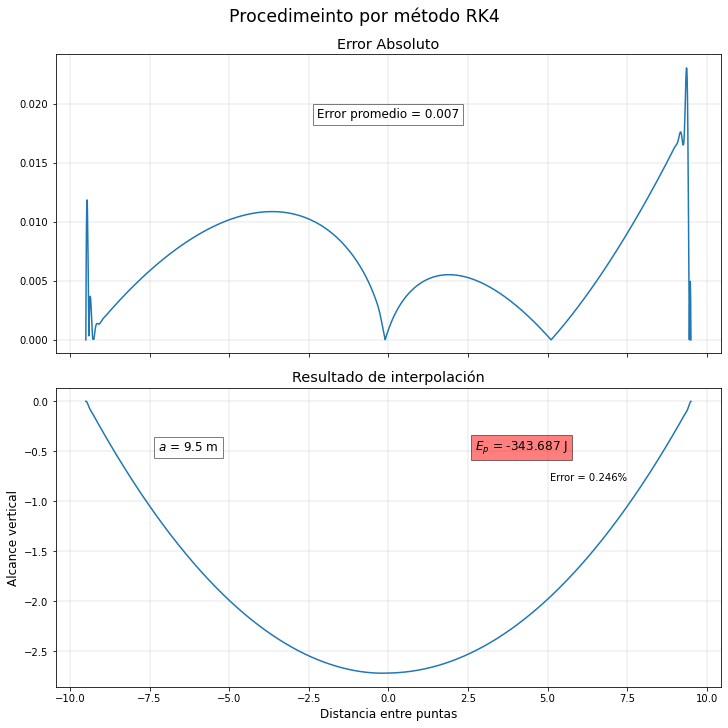

In [37]:
fig, ax = plt.subplots(2,1, constrained_layout=True, figsize=(10,10),sharex=True)

line, = ax[0].plot([],[])
line2, = ax[1].plot([],[])
ep = 0
er = 0
ap = 0
en = ax[1].text(0.7,0.8,f'$E_p$ = {ep} J',horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes,
                bbox=dict(facecolor='red', alpha=0.5), fontsize ='large')

enr =ax[1].text(0.8,0.7,f'Error = {er}%',horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes, 
                 fontsize ='medium')

an = ax[1].text(0.2,0.8,f'$a$ = {ap} m',horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes,
                bbox=dict(facecolor='white', alpha=0.5), fontsize ='large')

errprom = ax[0].text(0.5,0.8,f'Error promedio = {ap}',horizontalalignment='center',verticalalignment='center',transform=ax[0].transAxes,
                bbox=dict(facecolor='white', alpha=0.5), fontsize ='large')


fig.suptitle('Procedimeinto por método RK4',fontsize='xx-large')
ax[0].set_title('Error Absoluto',fontsize='x-large')
ax[1].set_title('Resultado de interpolación',fontsize='x-large')

ax[1].set_xlabel('Distancia entre puntas',fontsize='large')
ax[1].set_ylabel('Alcance vertical',fontsize='large')

ax[0].grid(True,linewidth=0.3)
ax[1].grid(True,linewidth=0.3)

func_args = np.linspace(0.5,10-0.5,30)

func_args[0] = 0.75
func_args[8] = 3
func_args[18] = 6
func_args[-3] = 8.8
func_args[-7] = 7.7
func_args[-8] = 7.4

dx = 0.1
def animate(i,func_params):
    a=func_params[i]
    
    f = lambda k: (a*rho*g)/(np.arcsinh((rho*g*L)/(k)))
    k = Steffensen2(f, -10)
    lam = k * np.cosh((rho*g*a)/(k))
    
    #Procedimiento para obtener solucion a la EDO por medio de RK4
    g0 = lambda y,k,lam,rho,g,x: np.sqrt(abs(((lam + rho*g*y) / (k))**2 - 1))    
    def function(y,x):
      #Convencion y = [x0,v0]
        y = p[0]
      #Derivadas
        dy = g0(y,k,lam,rho,g,x)
        f = [dy]
        return np.array(f)
    def function2(y,x):
      #Convencion y = [x0,v0]
        y = p[0]
      #Derivadas
        dy = -g0(y,k,lam,rho,g,x)
        f = [dy]
        return np.array(f)
    def RK4(f,y,t,dt):
        k1 = dx*f(y,x)
        k2 = dx*f(y+0.5*k1,x+0.5*dx)
        k3 = dx*f(y+0.5*k2,x+0.5*dx)
        k4 = dx*f(y+k3,x+dx)
        return y+1/6*(k1+2*k2+2*k3+k4)    
    x = np.arange(-a,a+dx,dx)
    y = np.zeros(len(x))
    y[0] =  0
    p = [y[0]]
    if a >=3: 
        x_ = np.arange(-a,-0.2+dx,dx)
    else:
        x_ = np.arange(-a,-0.3+dx,dx)
    for j in range(len(x_)-1):
        p = RK4(function,p,x[j],dx)
        y[j+1] = p[0]    
    for j in range(len(x_)-1,len(x)-1):
        p = RK4(function2,p,x[j],dx)
        y[j+1] = p[0]
    y[-1] = 0
    
    Sj = CubicSpline(x, y, bc_type='periodic')
    x__ = np.arange(-a,a+0.01,0.01)
    r = Sj(x__)
    r[-1] = 0
    y = lambda x: 1/(rho*g) * (-lam + k* np.cosh((rho*g*x)/(k)))
    
    xi = np.linspace(-a, a, 1001)
    yi = Sj(xi)*(1 + (Sj(xi, 1))**2)**0.5
    ep = -1*rho*g*Simpson2(xi,yi)
    en.set_text(f'$E_p$ = {np.round(ep,3)} J')
    
    an.set_text(f'$a$ = {np.round(a,3)} m')
    
    errpromlin=sum(abs(r-y(x__)))/len(abs(r-y(x__)))
    errprom.set_text(f'Error promedio = {np.round(errpromlin,3)}')
    
    epr = Integral_Gauss(lambda x: -1*(-lam + k* np.cosh((rho*g*x)/(k))) * (1 + (-np.sinh((rho*g*x)/(k)))**2)**0.5 , -a, a, 10)
    err = (abs((epr-ep)/(epr)))*100
    enr.set_text(f'Error = {np.round(err,3)}%')
    
    line.set_xdata(x__)
    line.set_ydata(abs(r-y(x__)))
    line2.set_xdata(x__)
    line2.set_ydata(-r)
    ax[0].relim()
    ax[0].autoscale_view()
    ax[1].relim()
    ax[1].autoscale_view()
    return line2, line, ax[0], ax[1]

ani = animation.FuncAnimation(fig, animate, fargs=(func_args,), frames = 30, interval=500)#, blit=True)#, save_count=50)

display(HTML(ani.to_jshtml()))

ani.save(filename='RK4.mp4')

Finalmente se realiza la misma animzación para la función real, con el fin de realizar una mejor comparación

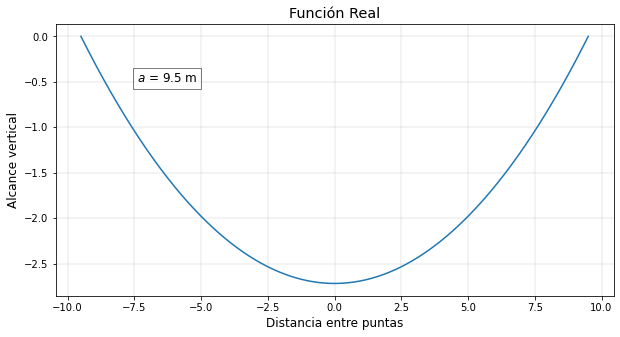

In [38]:
y = lambda x: 1/(rho*g) * (k * np.cosh((rho*g*a)/(k)) - k* np.cosh((rho*g*x)/(k)))

fig, ax = plt.subplots(figsize=(10,5))

line, = ax.plot([],[])
ap = 0
an = ax.text(0.2,0.8,f'$a$ = {ap} m',horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.5), fontsize ='large')

ax.set_title('Función Real',fontsize='x-large')

ax.set_xlabel('Distancia entre puntas',fontsize='large')
ax.set_ylabel('Alcance vertical',fontsize='large')

ax.grid(True,linewidth=0.3)

func_args = np.linspace(0.5,10-0.5,30)

func_args[0] = 0.75
func_args[8] = 3
func_args[18] = 6
func_args[-3] = 8.8
func_args[-7] = 7.7
func_args[-8] = 7.4
def animate(i,func_params):
    a=func_params[i]
    x = np.arange(-a,a+0.01,0.01)
    y = lambda x: 1/(rho*g) * (-k * np.cosh((rho*g*a)/(k)) + k* np.cosh((rho*g*x)/(k)))
    f = lambda k: (a*rho*g)/(np.arcsinh((rho*g*L)/(k)))
    k = Steffensen2(f, -10)
    r = y(x)
    an.set_text(f'$a$ = {np.round(a,3)} m')
    line.set_xdata(x)
    line.set_ydata(-r)
    ax.relim()
    ax.autoscale_view()
    return line, ax

ani = animation.FuncAnimation(fig, animate, fargs=(func_args,), frames = 30, interval=500)#, blit=True)#, save_count=50)

display(HTML(ani.to_jshtml()))
ani.save(filename='Real.mp4')